In [1]:
from wrangle_data_funcs import *
from modelling_funcs import *
from predict_gw_scores import *
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def get_ewma_df(year, gw, ewma_alpha):
    gw_df = import_data_from_vastaav(year, gw)
    gw_df = add_team_data(gw_df)

    gw_df['full_name'] = gw_df['name'].apply(clean_name)

    player_value_cols = ['xP', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'minutes',
       'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'saves', 'starts',
       'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'yellow_cards']
    merge_cols_players = ['full_name', 'gw', 'total_points', 'position','team','opponent_team']
    ewma_gw_df_players = ewma(gw_df, 'full_name', player_value_cols, ewma_alpha, {'total_points': 'ewma_total_points'}, merge_cols_players)

    gw_df_teams = get_teams_df(gw_df)
    team_value_cols = ['team_goals', 'team_points']
    merge_cols_teams = ['team', 'gw']
    ewma_gw_df_teams = ewma(gw_df_teams, 'team', team_value_cols, ewma_alpha, {'team_goals': 'ewma_team_goals',
                                                                            'team_points': 'ewma_team_points'}, merge_cols_teams)
    merged_ewma_df = merge_ewma_dfs(ewma_gw_df_players, ewma_gw_df_teams, year)
    return merged_ewma_df

In [3]:
def ewma(gw_df, groupby_col, value_cols, alpha, rename_dict, remerge_cols):
    # Ensure the DataFrame is sorted by 'full_name' and 'gw'
    gw_df_sorted = gw_df.sort_values([groupby_col, 'gw']).reset_index()

    # Apply EWMA within each group
    ewma_gw_df = (
        gw_df_sorted
        .groupby(groupby_col, group_keys=False)
        [value_cols]
        .apply(lambda x: x.ewm(alpha=alpha, adjust=False).mean())
    )
    ewma_gw_df.rename(columns=rename_dict, inplace=True)
    ewma_gw_df = gw_df_sorted[remerge_cols].join(ewma_gw_df)
    return ewma_gw_df

In [4]:
def roll(gw_df, groupby_col, value_cols, alpha, rename_dict, remerge_cols, rolling_gws):
    # Ensure the DataFrame is sorted by 'full_name' and 'gw'
    gw_df_sorted = gw_df.sort_values([groupby_col, 'gw']).reset_index()

    # Apply rolling mean within each group
    rolling_gw_df = (
        gw_df_sorted
        .groupby(groupby_col, group_keys=False)
        [value_cols]
        .apply(lambda x: x.rolling(window=rolling_gws, min_periods=1).mean())
    )
    rolling_gw_df.rename(columns=rename_dict, inplace=True)
    rolling_gw_df = gw_df_sorted[remerge_cols].join(rolling_gw_df)
    return rolling_gw_df

In [5]:
def get_rolling_df(year, gw, ewma_alpha, rolling_gws):
    gw_df = import_data_from_vastaav(year, gw)
    gw_df = add_team_data(gw_df)

    gw_df['full_name'] = gw_df['name'].apply(clean_name)

    player_value_cols = ['xP', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'minutes',
       'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'saves', 'starts',
       'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'yellow_cards']
    merge_cols_players = ['full_name', 'gw', 'total_points', 'position','team','opponent_team']
    ewma_gw_df_players = roll(gw_df, 'full_name', player_value_cols, ewma_alpha, {'total_points': 'ewma_total_points'}, merge_cols_players, rolling_gws)

    gw_df_teams = get_teams_df(gw_df)
    team_value_cols = ['team_goals', 'team_points']
    merge_cols_teams = ['team', 'gw']
    ewma_gw_df_teams = roll(gw_df_teams, 'team', team_value_cols, ewma_alpha, {'team_goals': 'ewma_team_goals',
                                                                            'team_points': 'ewma_team_points'}, merge_cols_teams, rolling_gws)
    merged_ewma_df = merge_ewma_dfs(ewma_gw_df_players, ewma_gw_df_teams, year)
    return merged_ewma_df

In [6]:
training_year, training_n_gws, pred_year, pred_gw, alpha, features, model, output = get_params()

In [7]:
year = training_year
n_gws = training_n_gws
alpha = alpha

In [8]:
ewma_df = get_ewma_df(year, n_gws, alpha)

In [9]:
roll_df = get_rolling_df(year, n_gws, alpha, rolling_gws=5)

In [10]:
##########

In [11]:
# get_training_df
year = training_year
n_gws = training_n_gws
alpha = alpha

# gw_df = ewma_df.copy()
gw_df = roll_df.copy()

training_df = lag_data_for_training(gw_df).dropna(subset=['total_points_nw'])
non_zero_players = training_df.groupby('full_name').sum().query('total_points_nw>0').index
training_df_f = training_df.query('gw>1 and full_name in @non_zero_players')


In [12]:
test_model(training_df_f, features, model)

{'GK': 2.182, 'DEF': 2.154, 'MID': 2.297, 'FWD': 2.844}


In [15]:
# Create a DataFrame from the new set of dictionaries
dicts2 = {
    'lin_roll_3': {'GK': 2.06, 'DEF': 2.148, 'MID': 2.26, 'FWD': 2.758},
    'lin_roll_5': {'GK': 2.125, 'DEF': 2.157, 'MID': 2.271, 'FWD': 2.785},
    'lin_ewma':   {'GK': 2.096, 'DEF': 2.14,  'MID': 2.239, 'FWD': 2.736},
    'xgb_ewma':   {'GK': 2.244, 'DEF': 2.148, 'MID': 2.262, 'FWD': 2.785},
    'xgb_roll_3': {'GK': 2.122, 'DEF': 2.147, 'MID': 2.268, 'FWD': 2.727},
    'xgb_roll_5': {'GK': 2.182, 'DEF': 2.154, 'MID': 2.297,  'FWD': 2.844}
}

df2 = pd.DataFrame.from_dict(dicts2, orient='index')

<Axes: xlabel='variable', ylabel='value'>

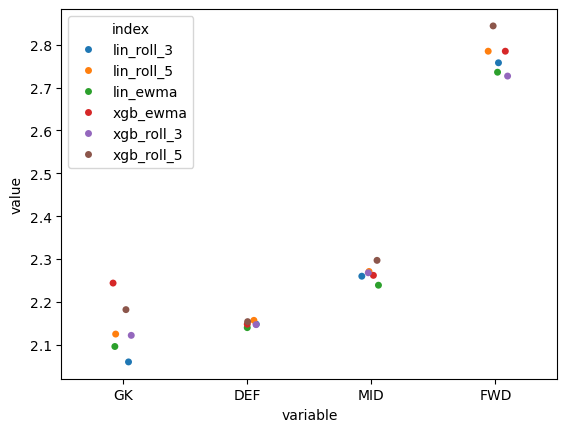

In [16]:
df_plot = df2.reset_index().melt(id_vars='index')
sns.stripplot(data=df_plot, y='value', x='variable', hue='index')

ewma =        {'GK': 2.096, 'DEF': 2.140, 'MID': 2.239, 'FWD': 2.736}

roll_3 =      {'GK': 2.060, 'DEF': 2.148, 'MID': 2.260, 'FWD': 2.758}
roll_5 =      {'GK': 2.125, 'DEF': 2.157, 'MID': 2.271, 'FWD': 2.785}
roll_7 =      {'GK': 2.176, 'DEF': 2.168, 'MID': 2.268, 'FWD': 2.771}
roll_38 =     {'GK': 2.207, 'DEF': 2.207, 'MID': 2.283, 'FWD': 2.777}

xgb_ewma =    {'GK': 2.244, 'DEF': 2.148, 'MID': 2.262, 'FWD': 2.785}

xgb_roll_3 =  {'GK': 2.016, 'DEF': 2.172, 'MID': 2.172, 'FWD': 2.65}
xgb_roll_5 =  {'GK': 2.182, 'DEF': 2.154, 'MID': 2.297, 'FWD': 2.844}
xgb_roll_7 =  {'GK': 2.247, 'DEF': 2.170, 'MID': 2.281, 'FWD': 2.914}
xgb_roll_38 = {'GK': 2.267, 'DEF': 2.192, 'MID': 2.292, 'FWD': 2.825}

In [31]:
ewma =        {'GK': 2.096, 'DEF': 2.140, 'MID': 2.239, 'FWD': 2.736}

roll_3 =      {'GK': 2.060, 'DEF': 2.148, 'MID': 2.260, 'FWD': 2.758}
roll_5 =      {'GK': 2.125, 'DEF': 2.157, 'MID': 2.271, 'FWD': 2.785}
roll_7 =      {'GK': 2.176, 'DEF': 2.168, 'MID': 2.268, 'FWD': 2.771}
roll_38 =     {'GK': 2.207, 'DEF': 2.207, 'MID': 2.283, 'FWD': 2.777}

xgb_ewma =    {'GK': 2.244, 'DEF': 2.148, 'MID': 2.262, 'FWD': 2.785}

xgb_roll_3 =  {'GK': 2.016, 'DEF': 2.172, 'MID': 2.172, 'FWD': 2.65}
xgb_roll_5 =  {'GK': 2.182, 'DEF': 2.154, 'MID': 2.297, 'FWD': 2.844}
xgb_roll_7 =  {'GK': 2.247, 'DEF': 2.170, 'MID': 2.281, 'FWD': 2.914}
xgb_roll_38 = {'GK': 2.267, 'DEF': 2.192, 'MID': 2.292, 'FWD': 2.825}

In [33]:
# Create a DataFrame from the given dictionaries
dicts = {
    'ewma':        {'GK': 2.096, 'DEF': 2.140, 'MID': 2.239, 'FWD': 2.736},
    'roll_3':      {'GK': 2.060, 'DEF': 2.148, 'MID': 2.260, 'FWD': 2.758},
    'roll_5':      {'GK': 2.125, 'DEF': 2.157, 'MID': 2.271, 'FWD': 2.785},
    'roll_7':      {'GK': 2.176, 'DEF': 2.168, 'MID': 2.268, 'FWD': 2.771},
    'roll_38':     {'GK': 2.207, 'DEF': 2.207, 'MID': 2.283, 'FWD': 2.777},
    'xgb_ewma':    {'GK': 2.244, 'DEF': 2.148, 'MID': 2.262, 'FWD': 2.785},
    'xgb_roll_3':  {'GK': 2.016, 'DEF': 2.172, 'MID': 2.172, 'FWD': 2.65},
    'xgb_roll_5':  {'GK': 2.182, 'DEF': 2.154, 'MID': 2.297, 'FWD': 2.844},
    'xgb_roll_7':  {'GK': 2.247, 'DEF': 2.170, 'MID': 2.281, 'FWD': 2.914},
    'xgb_roll_38': {'GK': 2.267, 'DEF': 2.192, 'MID': 2.292, 'FWD': 2.825}
}

df = pd.DataFrame.from_dict(dicts, orient='index')

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
df_plot = df.reset_index().melt(id_vars='index')

In [52]:
df_plot.query('index in ["ewma", "xgb_roll_3", "xgb_roll_5"]')

,index,variable,value
0,ewma,GK,2.096
6,xgb_roll_3,GK,2.016
7,xgb_roll_5,GK,2.182
10,ewma,DEF,2.140
16,xgb_roll_3,DEF,2.172
17,xgb_roll_5,DEF,2.154
20,ewma,MID,2.239
26,xgb_roll_3,MID,2.172
27,xgb_roll_5,MID,2.297
30,ewma,FWD,2.736


<Axes: xlabel='variable', ylabel='value'>

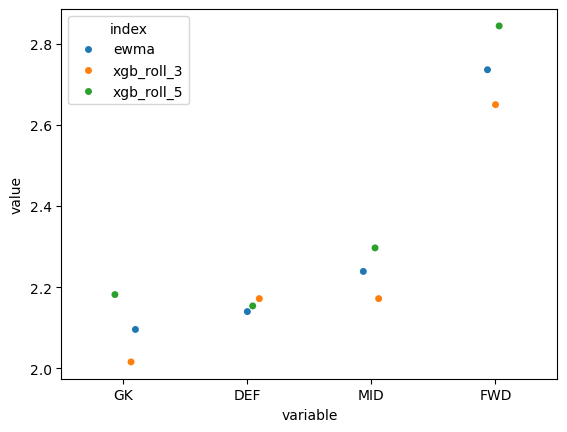

In [54]:
sns.stripplot(data=df_plot.query('index in ["ewma", "xgb_roll_3", "xgb_roll_5"]'), y='value', x='variable', hue='index')